# Automatic Detection of Hot-Rolled Steel Strips Surface Defects using Convolutional Neural Network
#### This project aims to automatically detect surface defects in Hot-Rolled Steel Strips such as rolled-in scale, patches, crazing, pitted surface, inclusion and scratches (as depicted in the image below). A Convolutional Neural Network Model is developed and trained on the NEU Metal Surface Defects Database which contains 1800 grayscale images with 300 samples of each of the six different kinds of surface defects.

## 1. Importing Relevant Libraries

In [7]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt 
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.datasets import load_files
# from tensorflow.keras.utils import np_utils
import np_utils
from keras.preprocessing.image import array_to_img, img_to_array, load_img

## 2. Importing the NEU Metal Surface Defect Dataset

In [10]:
# 定义路径
train_dir = '../NEU Metal Surface Defects Data/train'
val_dir = '../NEU Metal Surface Defects Data/valid'
test_dir = '../NEU Metal Surface Defects Data/test'

# 检查并打印路径下的目录和文件
def list_directory_contents(path, description):
    try:
        contents = os.listdir(path)
        print(f"{description}: {contents}")
    except FileNotFoundError:
        print(f"Error: {path} not found.")
    except NotADirectoryError:
        print(f"Error: {path} is not a directory.")
    except PermissionError:
        print(f"Error: Permission denied for {path}.")

base_dir = '../NEU Metal Surface Defects Data'
list_directory_contents(base_dir, "Path")
list_directory_contents(train_dir, "Train")
list_directory_contents(test_dir, "Test")
list_directory_contents(val_dir, "Validation")

Path: ['valid', 'test', 'train']
Train: ['Inclusion', 'Patches', 'Rolled', 'Pitted', 'Scratches', 'Crazing']
Test: ['Inclusion', 'Patches', 'Rolled', 'Pitted', 'Scratches', 'Crazing']
Validation: ['Inclusion', 'Patches', 'Rolled', 'Pitted', 'Scratches', 'Crazing']


#### For each Class, the Training Data includes 276 Images, Validation & Test sets have 12 images each.

In [11]:
print("Inclusion Defect")
print("Training Images:",len(os.listdir(train_dir+'/'+'Inclusion')))
print("Testing Images:",len(os.listdir(test_dir+'/'+'Inclusion')))
print("Validation Images:",len(os.listdir(val_dir+'/'+'Inclusion')))

Inclusion Defect
Training Images: 276
Testing Images: 12
Validation Images: 12


## 3. Data Pre-processing

In [12]:
# Rescaling all Images by 1./255
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

# Training images are put in batches of 10
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(200, 200),
        batch_size=10,
        class_mode='categorical')

# Validation images are put in batches of 10
validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(200, 200),
        batch_size=10,
        class_mode='categorical')

Found 1656 images belonging to 6 classes.
Found 72 images belonging to 6 classes.


#### Setting upper Limit of Max 98% training accuracy

In [13]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.98 ):
            print("\nReached 98% accuracy so cancelling training!")
            self.model.stop_training = True 

## 4. Defining the CNN Architecture

In [14]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (2,2), activation='relu', input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.summary()

/opt/anaconda3/envs/dl/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 199, 199, 32)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 98, 98, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 49, 49, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    18,874,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,917,734 (72.17 MB)

 Trainable params: 18,917,734 (72.17 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [20]:
tf.keras.utils.plot_model(
    model,
    to_file='cnn_architecture.png',
    show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


## 5. Training the Defined CNN Model

In [21]:
callbacks = myCallback()
history = model.fit(train_generator,
        batch_size = 32,
        epochs=20,
        validation_data=validation_generator,
        callbacks=[callbacks],
        verbose=1, shuffle=True)

Epoch 1/20


/opt/anaconda3/envs/dl/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


166/166 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.2113 - loss: 2.5041 - val_accuracy: 0.5417 - val_loss: 1.3233
Epoch 2/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.4497 - loss: 1.4150 - val_accuracy: 0.3194 - val_loss: 2.3566
Epoch 3/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.6192 - loss: 1.0499 - val_accuracy: 0.7917 - val_loss: 0.7360
Epoch 4/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.7161 - loss: 0.8183 - val_accuracy: 0.8750 - val_loss: 0.5751
Epoch 5/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.7919 - loss: 0.6540 - val_accuracy: 0.7639 - val_loss: 0.6989
Epoch 6/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.8115 - loss: 0.5999 - val_accuracy: 0.9306 - val_loss: 0.1539
Epoch 7/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.8447 - loss: 0.5144 - val_accuracy: 0.9306 - val_loss: 0.1792
Epoch 8/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.8623 - loss: 0.4486 - val_accurac

## 6. Analysing the Accuracy & the Loss Curves

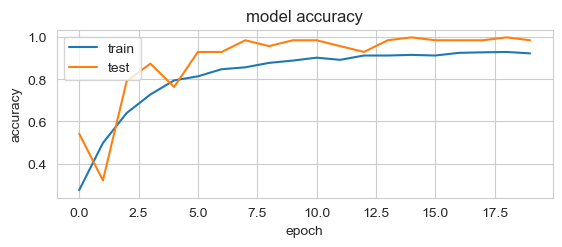

In [22]:
sns.set_style("whitegrid")
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')
plt.show()

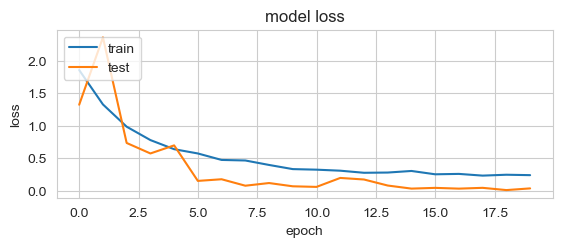

In [23]:
sns.set_style("whitegrid")
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')  
plt.show()

## 7. Test Result visualization

In [24]:
# Loading file names & their respective target labels into numpy array
def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels
x_test, y_test,target_labels = load_dataset(test_dir)
no_of_classes = len(np.unique(y_test))
no_of_classes

6

In [26]:
# y_test = np_utils.to_categorical(y_test,no_of_classes)
from keras.utils import to_categorical

y_test = to_categorical(y_test, num_classes=no_of_classes)

In [27]:
def convert_image_to_array(files):
    images_as_array=[]
    for file in files:
        # Convert to Numpy Array
        images_as_array.append(img_to_array(load_img(file)))
    return images_as_array

x_test = np.array(convert_image_to_array(x_test))
print('Test set shape : ',x_test.shape)

Test set shape :  (72, 200, 200, 3)


In [28]:
x_test = x_test.astype('float32')/255

## Results of Hot-Rolled Steel Strips Surface Defect Detection

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


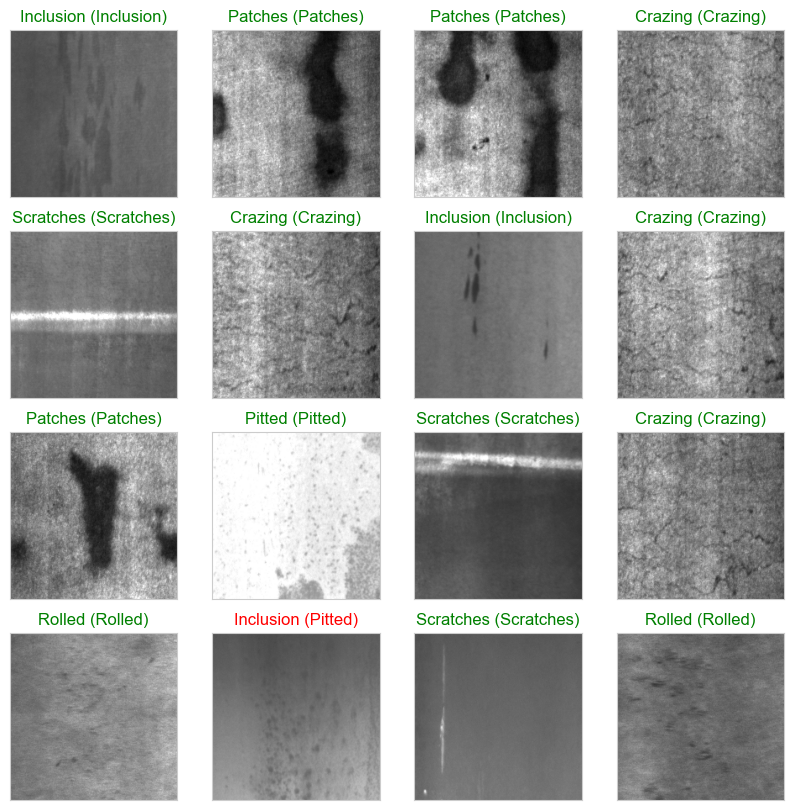

In [29]:
# Plotting Random Sample of test images, their predicted labels, and ground truth
y_pred = model.predict(x_test)
fig = plt.figure(figsize=(10, 10))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))